In [ ]:
# import mteb

# benchmarks = mteb.get_benchmarks()

# benchmarks

In [ ]:
import torch
import torch.nn.functional as F
import numpy
from transformers import AutoTokenizer, AutoModel
import os

from scipy.stats import spearmanr
from datasets import load_dataset

base_tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
base_model = AutoModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base").to(
    "cuda"
)
base_model.eval()

# our_model = AutoModel.from_pretrained(
#     "/home/decycle/ML/simcse_finetune/test_trainer/checkpoint-64800"
# ).to("cuda")

our_model = AutoModel.from_pretrained(
    "/home/decycle/ML/simcse_finetune/test_trainer_v4/checkpoint-50400"
).to("cuda")

our_model.eval()

good_model = AutoModel.from_pretrained(
    "jinaai/jina-embeddings-v3", trust_remote_code=True
).to("cuda")
good_model.eval()

good_tokenizer = AutoTokenizer.from_pretrained(
    "jinaai/jina-embeddings-v3", trust_remote_code=True
)

In [ ]:
from tqdm import trange


class SentenceEmbedder:
    def __init__(self, model, tokenizer, dim=768, max_length=512):
        self.model = model
        self.tokenizer = tokenizer
        self.dim = dim
        self.max_length = max_length

    def encode(
        self, sentences, max_length=512, batch_size=4, convert_to_tensor=True, **kwargs
    ):
        self.model.eval()
        with torch.no_grad():
            inputs = self.tokenizer(
                sentences,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=self.max_length,
            )
            input_ids = inputs["input_ids"].to("cuda")
            attention_mask = inputs["attention_mask"].to("cuda")

            embeddings = torch.zeros(len(sentences), self.dim).to("cuda")
            for i in trange(0, len(sentences), batch_size):
                batch_input_ids = input_ids[i : i + batch_size]
                batch_attention_mask = attention_mask[i : i + batch_size]
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask,
                )
                embeddings[i : i + batch_size] = outputs.pooler_output
            if convert_to_tensor:
                return embeddings
            else:
                return embeddings.cpu().numpy()

In [ ]:
import mteb

benchmark = mteb.get_benchmark("LongEmbed")

In [ ]:
def evaluate(model, output_dir, batch_size):
    evaluation = mteb.MTEB(tasks=benchmark)
    # TODO load the model before evaluation
    results = evaluation.run(
        model,
        output_folder=output_dir,
        overwrite_results=True,
        batch_size=batch_size,
        verbosity=0,
    )
    return results

our_embedder = SentenceEmbedder(our_model, base_tokenizer, dim=768, max_length=512)
base_embedder = SentenceEmbedder(base_model, base_tokenizer, dim=768, max_length=512)
good_embedder = SentenceEmbedder(good_model, good_tokenizer, dim=1024, max_length=8194)
our_results = evaluate(our_embedder, "output_dir_our", 32)
base_results = evaluate(base_embedder, "output_dir_base", 32)
good_results = evaluate(good_embedder, "output_dir_good", 32)

In [ ]:
def get_scores(results):
    scores = {}
    for result in results:
        name = result.task_name
        score = list(result.scores.values())[0]
        if name in ['LEMBPasskeyRetrieval', 'LEMBNeedleRetrieval']:
            score = score[0]["main_score"]
        else:
            score = score[0]["main_score"]
        scores[name] = score
    return scores

our_scores = get_scores(our_results)
base_scores = get_scores(base_results)
good_scores = get_scores(good_results)

In [ ]:
our_scores, base_scores, good_scores

In [ ]:
# our_scores, base_scores, good_scores = (
#     {
#         "LEMBNarrativeQARetrieval": 0.13626,
#         "LEMBNeedleRetrieval": 0.64,
#         "LEMBPasskeyRetrieval": 0.6,
#         "LEMBQMSumRetrieval": 0.1492,
#         "LEMBSummScreenFDRetrieval": 0.52895,
#         "LEMBWikimQARetrieval": 0.3503,
#     },
#     {
#         "LEMBNarrativeQARetrieval": 0.08723,
#         "LEMBNeedleRetrieval": 0.26,
#         "LEMBPasskeyRetrieval": 0.48,
#         "LEMBQMSumRetrieval": 0.14554,
#         "LEMBSummScreenFDRetrieval": 0.47519,
#         "LEMBWikimQARetrieval": 0.33434,
#     },
#     {
#         "LEMBNarrativeQARetrieval": 0.30743,
#         "LEMBNeedleRetrieval": 0.66,
#         "LEMBPasskeyRetrieval": 1.0,
#         "LEMBQMSumRetrieval": 0.33367,
#         "LEMBSummScreenFDRetrieval": 0.91128,
#         "LEMBWikimQARetrieval": 0.68078,
#     },
# )

In [ ]:
# import numpy as np

# base_avg = np.mean(list(base_scores.values()))
# our_avg = np.mean(list(our_scores.values()))
# good_avg = np.mean(list(good_scores.values()))

# base_avg, our_avg, good_avg

(np.float64(0.29705000000000004),
 np.float64(0.40078499999999995),
 np.float64(0.64886))

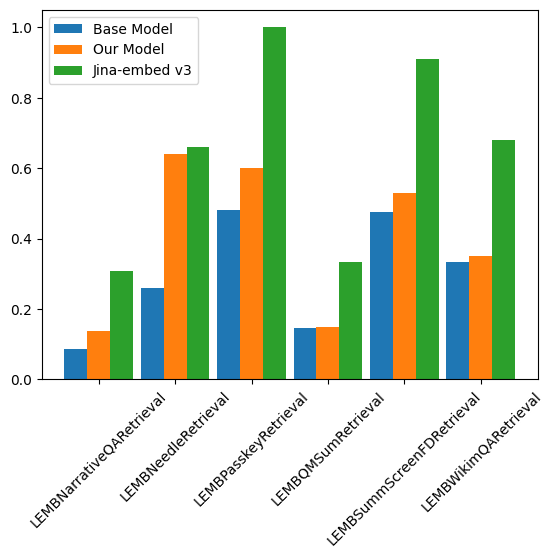

In [ ]:
# three bar graph
import matplotlib.pyplot as plt
width = 0.3

fig, ax = plt.subplots()

x = np.arange(len(our_scores))
ax.bar(x - width, base_scores.values(), width, label="Base Model")
ax.bar(x, our_scores.values(), width, label='Our Model')
ax.bar(x + width, good_scores.values(), width, label='Jina-embed v3')

ax.set_xticks(x)
ax.set_xticklabels(our_scores.keys(), rotation=45)
ax.legend()
plt.show()

In [ ]:
good_results

In [ ]:
our_result = our_results[0].scores["test"][0]
base_result = base_results[0].scores["test"][0]
good_result = good_results[0].scores["test"][0]

In [ ]:
# compare every key in the result dict
from matplotlib import pyplot as plt

labels = []
our_scores = []
base_scores = []
good_scores = []

for key in our_result.keys():
    our_score = our_result[key]
    base_score = base_result[key]
    good_score = good_result[key]

    if type(our_score) in [str, list, dict]:
        continue

    our_score = float(our_score)
    base_score = float(base_score)
    good_score = float(good_score)

    labels.append(key)
    our_scores.append(our_score)
    base_scores.append(base_score)
    good_scores.append(good_score)


# print(our_scores)
# bar graph
x = numpy.arange(len(labels))

# 10 per graph
for i in range(0, len(labels), 10):
    plt.figure(figsize=(20, 10))
    # bar graph with bottom highest score last
    plt.bar(x[i:i+10], good_scores[i:i+10], label="Good Model")
    plt.bar(x[i:i+10], our_scores[i:i+10], label="Our Model")
    plt.bar(x[i:i+10], base_scores[i:i+10], label="Base Model")

    plt.ylabel("Scores")
    plt.title("Scores by task")
    plt.xticks(x[i:i+10], labels[i:i+10])
    plt.legend()
    plt.show()

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width / 2, our_scores, width, label="Our Model")
# rects2 = ax.bar(x + width/2, base_scores, width, label="Base Model")

# ax.set_ylabel("Scores")
# ax.set_title("Scores by task")
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# plt.show()

In [ ]:
dataset = load_dataset(
    "abokbot/wikipedia-first-paragraph",
    split="train",
    trust_remote_code=True,
)[:100000]['text']

In [ ]:
from tqdm import tqdm, trange

def tokenize_function(examples):
    sizes = []
    for example in examples['text']:
        sizes.append(len(base_tokenizer(example)["input_ids"]))
    return sizes

sizes = []
batch_size = 1024
for i in trange(0, len(dataset), batch_size):
    sizes.extend(tokenize_function({"text": dataset[i : i + batch_size]}))

In [ ]:
# histogram
plt.hist(sizes, bins=100)
plt.show()

In [ ]:
# top 95% of the data
sizes = numpy.array(sizes)
top_95 = numpy.percentile(sizes, 85)
print(top_95)

In [ ]:
import numpy as np

a = np.array([3])

a[0]

isinstance(a[0], np.int64)